In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import sys
import os
sys.path.append(os.path.abspath("../"))

from scripts.evaluate import evaluate_forecasts
from scripts.visualization import *

import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
df_brl = pd.read_parquet('../data/all_comm/comm_brl.parquet')
df_usd = pd.read_parquet('../data/all_comm/comm_usd.parquet')

In [4]:
def extract_series(df):
    """
    Extrai informações relevantes de uma série temporal presente em um DataFrame agrupado por 'unique_id'.

    Para cada série identificada por 'unique_id', retorna:
    - a série completa,
    - os valores da variável alvo 'y',
    - os últimos 6 valores de 'y' (lags atuais).

    Parâmetros:
    -----------
    df : pandas.DataFrame
        DataFrame contendo colunas 'unique_id' e 'y'.

    Retorna:
    --------
    dict
        Dicionário em que a chave é o 'unique_id' da série, e o valor é um dicionário com:
        - 'series': DataFrame da série completa,
        - 'y_series': array com os valores da série,
        - 'v_curr_lags': últimos 6 valores (lags) da série.
    """
    series_data = {}

    for uid in df['unique_id'].unique():
        series = df[df['unique_id'] == uid]
        y_series = series['y'].values
        last_6_lags = y_series[-6:]

        series_data[uid] = {
            'series': series,
            'y_series': y_series,
            'v_curr_lags': last_6_lags
        }

    return series_data

# series_data_brl['SOJA']['series']: DataFrame da série de soja brl
# series_data_brl['SOJA']['y_series']: array dos valores y da soja brl
# series_data_brl['SOJA']['v_curr_lags']: últimos 6 valores de y da soja brl

# series_data_usd['SOJA']['series']: DataFrame da série de soja usd
# series_data_usd['SOJA']['y_series']: array dos valores y da soja usd
# series_data_usd['SOJA']['v_curr_lags']: últimos 6 valores de y da soja usd

In [5]:
def extract_lag_windows(series, window_size=6):
    """
    Extrai as janelas (lags) de uma série temporal para preparação dos dados de entrada
    e saída dos modelos.

    Para cada ponto no tempo, a função cria uma janela contendo os `window_size` valores anteriores,
    e associa essa janela ao valor seguinte da série como alvo (target).

    Parâmetros:
    -----------
    series : array-like
        Série temporal univa    riada (lista ou array do NumPy).
    
    window_size : int, opcional (default=6)
        Quantidade de valores anteriores (lags) que serão usados para formar as janelas.

    Retorna:
    --------
    tuple of np.ndarray
        - windows: array 2D de shape (n amostras, window_size), contendo as janelas de entrada.
        - targets: array 1D de shape (n amostras,), contendo os valores futuros correspondentes.
    """
    windows = []
    targets = []
    for i in range(window_size, len(series)-1):
        windows.append(series[i-window_size:i])
        targets.append(series[i])
    return np.array(windows), np.array(targets)

In [6]:
def evaluate_models(models, X, y):
    """
    Avalia um conjunto de modelos de regressão utilizando o erro quadrático médio (MSE)
    em um conjunto de dados fornecido.

    Cada modelo é treinado com os dados (X, y) e avaliado com previsões sobre o mesmo X.

    Parâmetros:
    -----------
    models : list
        Lista de modelos de regressão que implementam os métodos `.fit()` e `.predict()`.

    X : np.ndarray
        Matriz de entrada (janelas de lags).

    y : np.ndarray
        Vetor de saída (valores futuros correspondentes às janelas).

    Retorna:
    --------
    np.ndarray
        Vetor com os erros (MSE) de cada modelo na ordem em que foram fornecidos.
    """
    scores = []
    for model in models:
        model.fit(X, y)
        y_pred = model.predict(X)
        score = mean_squared_error(y, y_pred)
        scores.append(score)
    return np.array(scores)

In [7]:
def plot_forecast(y_series, forecast, horizon, series_id):
    """
    Gera o gráfico da série real e da previsão recursiva.

    Parâmetros:
    -----------
    y_series : array-like
        Série temporal completa com valores reais.

    forecast : array-like
        Lista de valores previstos para os próximos `horizon` passos.

    horizon : int
        Número de passos futuros previstos.

    series_id : str
        Identificador da série (usado no título do gráfico).

    Retorna:
    --------
    None
        Exibe o gráfico com a série real e os valores previstos.
    """
    x_real = np.arange(len(y_series))
    x_forecast = np.arange(len(y_series) - horizon, len(y_series))

    plt.figure(figsize=(14, 5))
    plt.plot(x_real, y_series, label='Série real', color='blue')
    plt.plot(x_forecast, forecast, label='Previsão', color='orange')
    plt.title(f'{series_id} - Previsão Recursiva de {horizon} passos com DCS-LA')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
# poool de preditores

models = [
    LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbose=-1
    ),
    XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbosity=0
    ),
    KNeighborsRegressor(
        n_neighbors=5,
        weights='distance'
    ),
    MLPRegressor(
        hidden_layer_sizes=(50, 25),
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=3,
        random_state=42
    )
]

In [9]:
series_data_brl = extract_series(df_brl)
series_data_usd = extract_series(df_usd)

# Params
horizon_size = 12  # número de passos futuros a prever
window_size = 6 # tamanho da janela

## BRL

### Similaridade por Cosseno


==> Série: ACUCAR
Valores reais:     [143.58, 147.15, 138.98, 135.73, 133.13, 130.74, 141.13, 152.82, 166.46, 161.64, 155.31, 145.23]
Valores previstos: [128.34, 112.78, 63.98, 53.49, 55.33, 52.07, 55.68, 59.31, 56.91, 63.18, 73.25, 78.95]
MSE da previsão recursiva (12 passos): 6242.2347


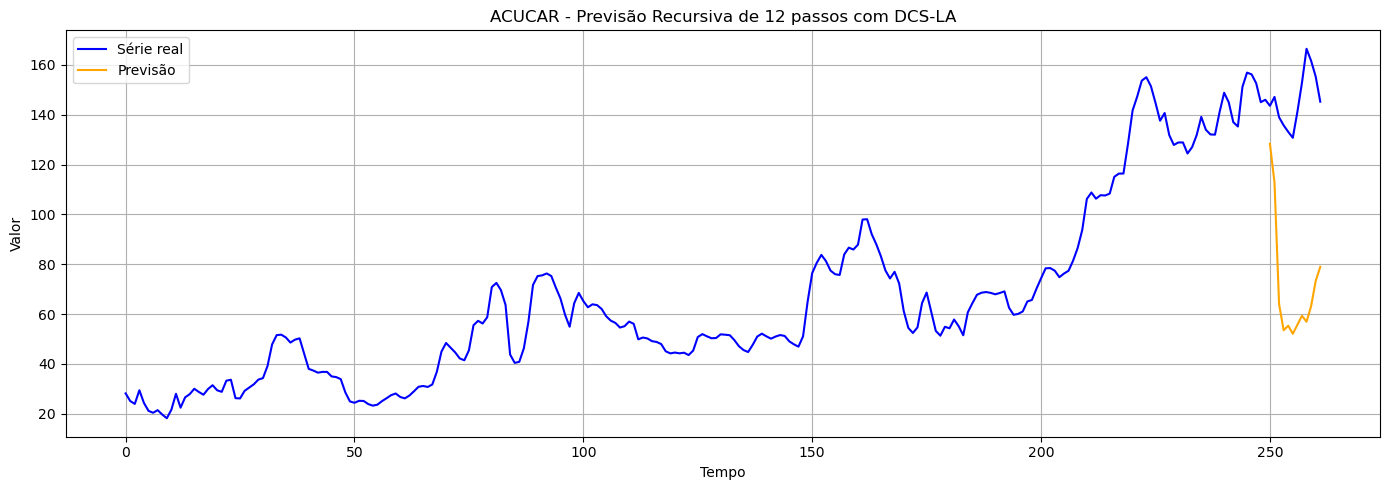


==> Série: ALGODAO
Valores reais:     [420.34, 397.87, 384.75, 392.34, 406.95, 399.44, 395.98, 396.05, 395.15, 413.79, 414.5, 411.24]
Valores previstos: [211.43, 263.91, 226.2, 230.69, 195.96, 184.17, 174.23, 150.9, 156.94, 155.05, 152.34, 140.49]
MSE da previsão recursiva (12 passos): 48225.5360


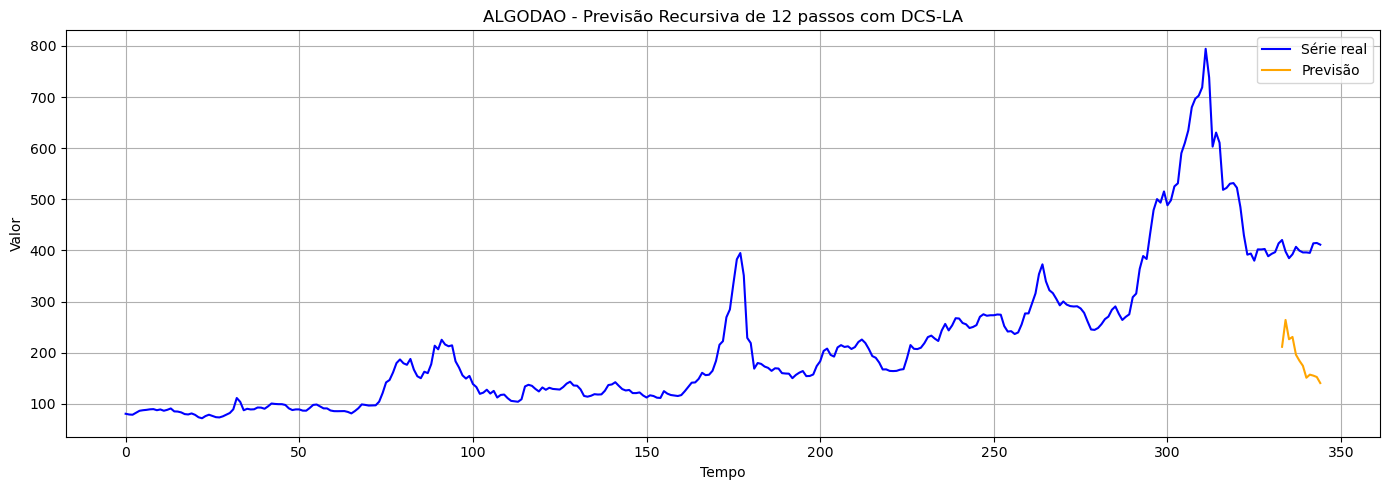


==> Série: CAFE
Valores reais:     [1013.92, 1214.35, 1175.42, 1349.22, 1419.72, 1431.37, 1472.73, 1490.14, 1776.55, 2154.89, 2332.87, 2680.3]
Valores previstos: [902.79, 771.17, 794.36, 784.0, 858.03, 878.25, 902.02, 870.76, 403.09, 687.5, 765.9, 667.16]
MSE da previsão recursiva (12 passos): 1045995.0416


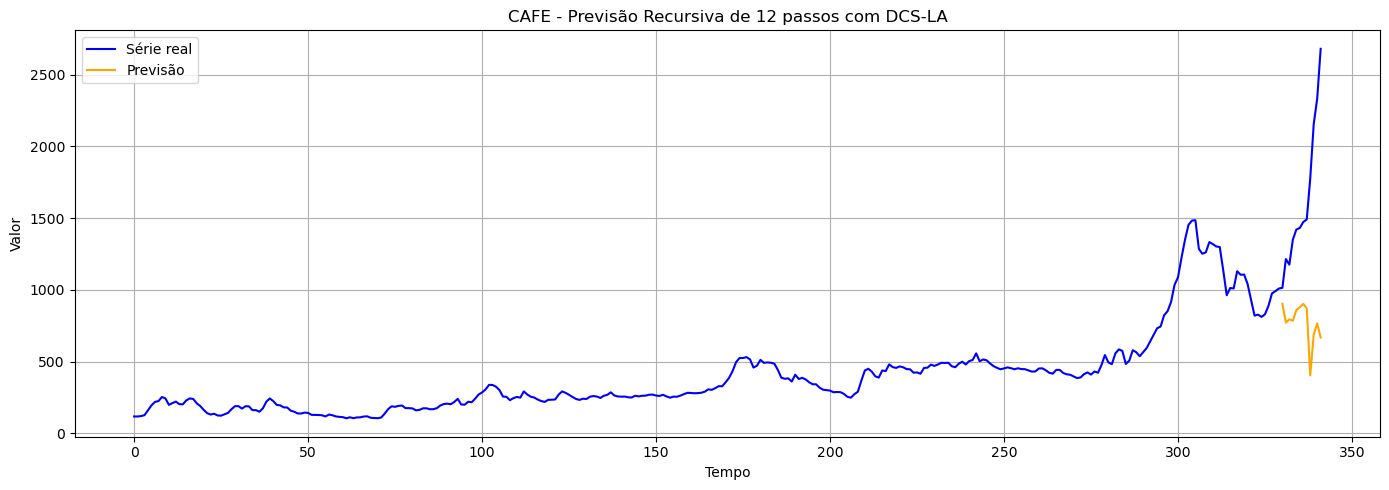


==> Série: MILHO
Valores reais:     [62.72, 59.63, 58.92, 57.86, 57.22, 59.58, 62.6, 68.79, 73.68, 72.92, 74.17, 77.97]
Valores previstos: [56.38, 48.8, 43.87, 39.89, 45.08, 32.95, 30.85, 28.82, 26.23, 24.56, 23.74, 24.4]
MSE da previsão recursiva (12 passos): 1181.0044


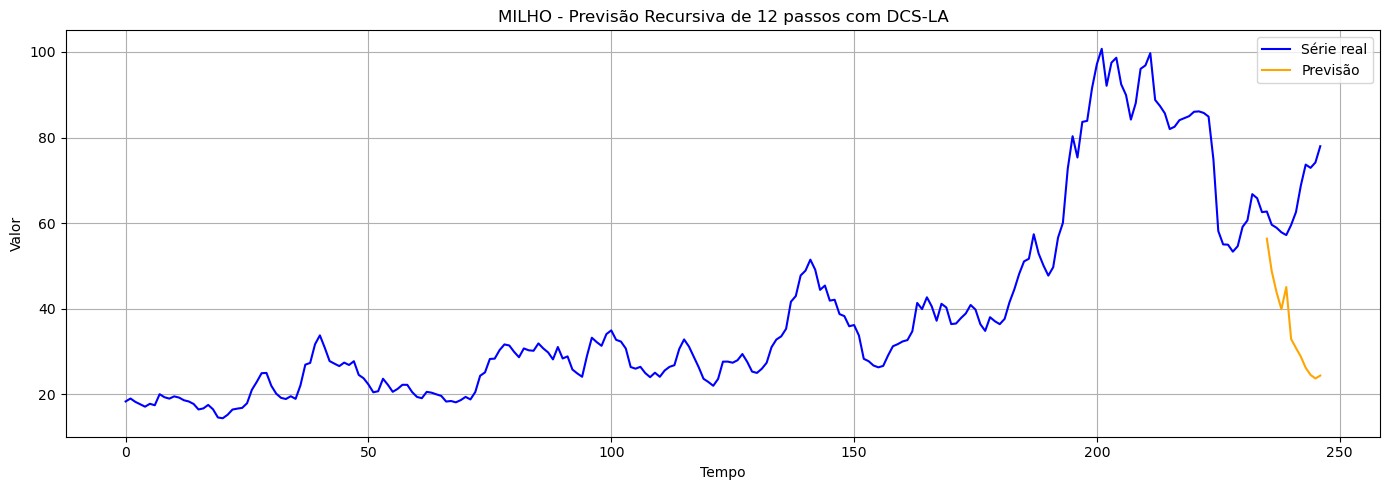


==> Série: SOJA
Valores reais:     [121.91, 126.79, 136.0, 138.92, 138.09, 133.21, 139.9, 141.83, 143.41, 141.17, 134.62, 131.1]
Valores previstos: [121.11, 113.44, 95.85, 101.23, 94.08, 88.09, 83.88, 76.94, 73.98, 76.15, 76.01, 73.13]
MSE da previsão recursiva (12 passos): 2531.5565


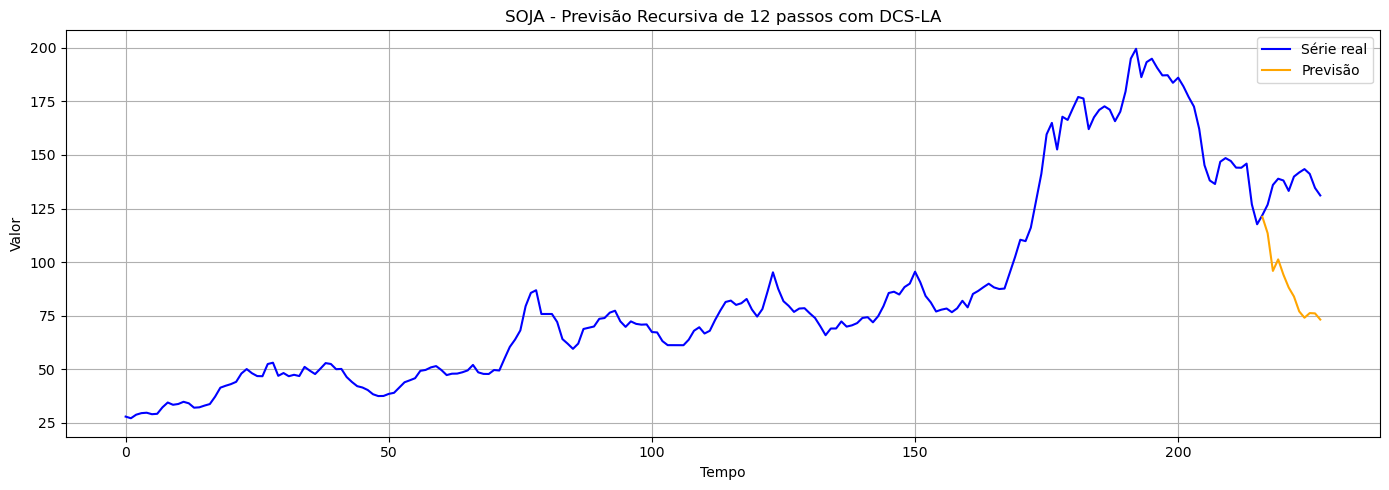

In [ ]:
for id in df_brl['unique_id'].unique():
    print(f'\n==> Série: {id}')

    y_series = series_data_brl[id]['y_series']     # array com os valores alvo da série
    y_real_future = y_series[-horizon_size:]       # últimos 12 pontos reais para avaliação
    y_train = y_series[:-horizon_size]             # parte separada para gerar as janelas e treinar os modelos

    curr_lags = y_train[-window_size:]             # criação da primeira região de dependência (últimos *window_size* pontos do treino)
    forecast = []                                  # lista para add os *horizon_size* valores previstos

    for step in range(horizon_size):
        # extrai janelas e targets do histórico até agora (incluindo previsões anteriores)
        windows, targets = extract_lag_windows(y_train, window_size=window_size)

        # calcula similaridade da região atual com todas janelas anteriores
        sims = cosine_similarity([curr_lags], windows)[0]
        top_k_idx = sims.argsort()[-10:]  # top 10 janelas mais similares

        competence_X = windows[top_k_idx]
        competence_y = targets[top_k_idx]

        # seleciona o melhor modelo com base no erro (MSE)
        errors = evaluate_models(models, competence_X, competence_y)
        best_model = models[np.argmin(errors)]

        # realiza a previsão para o próximo ponto
        y_next = best_model.predict([curr_lags])[0]
        forecast.append(y_next)

        # atualiza os lags e o histórico com o valor previsto
        curr_lags = np.append(curr_lags[1:], y_next)
        y_train = np.append(y_train, y_next)

    # avaliação dos valores reais e previstos + mse
    print("Valores reais:    ", y_real_future.round(2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    mse = mean_squared_error(y_real_future, forecast)
    print(f"MSE da previsão recursiva ({horizon_size} passos): {mse:.4f}")

    plot_forecast(y_series, forecast, horizon_size, id)

### Similaridade por Distância Euclidiana


==> Série: ACUCAR
Valores reais:     [143.58, 147.15, 138.98, 135.73, 133.13, 130.74, 141.13, 152.82, 166.46, 161.64, 155.31, 145.23]
Valores previstos: [138.35, 136.73, 132.71, 130.12, 128.45, 127.98, 127.22, 129.43, 132.33, 134.35, 134.03, 132.91]
MSE da previsão recursiva (12 passos): 290.8435


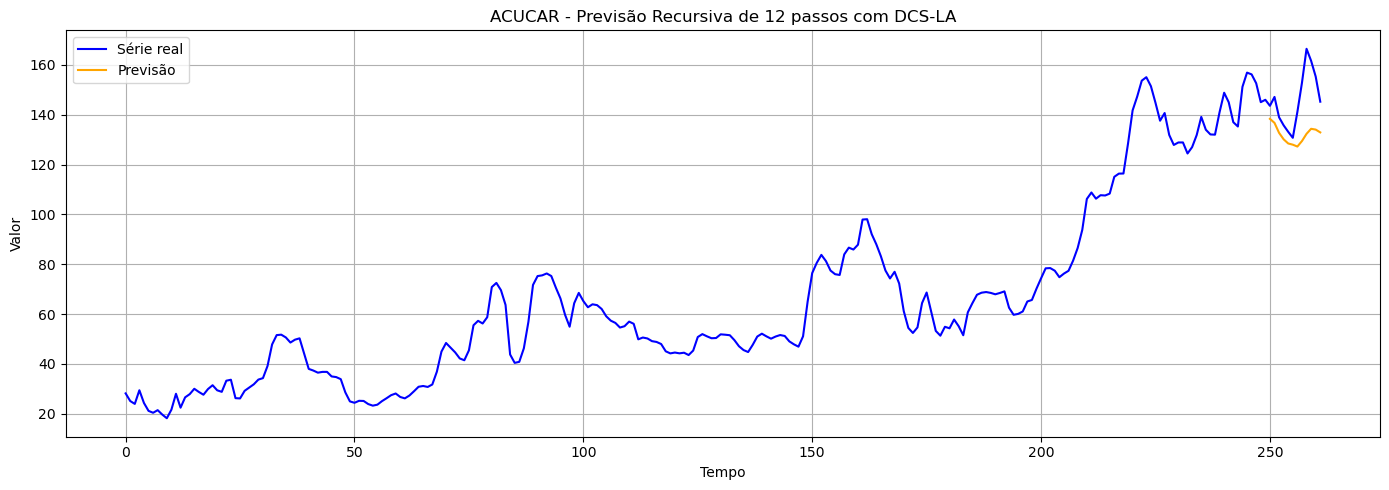


==> Série: ALGODAO
Valores reais:     [420.34, 397.87, 384.75, 392.34, 406.95, 399.44, 395.98, 396.05, 395.15, 413.79, 414.5, 411.24]
Valores previstos: [394.97, 398.21, 396.6, 400.7, 398.95, 402.52, 398.54, 403.02, 399.77, 403.18, 401.04, 402.13]
MSE da previsão recursiva (12 passos): 115.0680


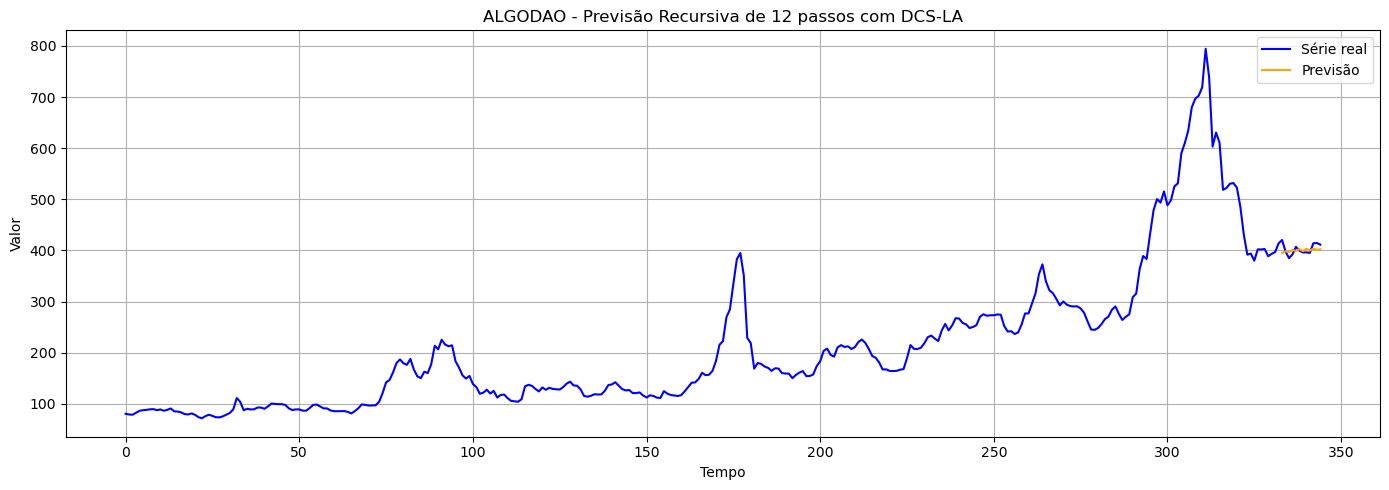


==> Série: CAFE
Valores reais:     [1013.92, 1214.35, 1175.42, 1349.22, 1419.72, 1431.37, 1472.73, 1490.14, 1776.55, 2154.89, 2332.87, 2680.3]
Valores previstos: [1135.27, 1172.82, 1181.23, 1139.25, 1010.73, 975.29, 925.19, 911.77, 837.78, 844.98, 866.15, 905.51]
MSE da previsão recursiva (12 passos): 747369.4269


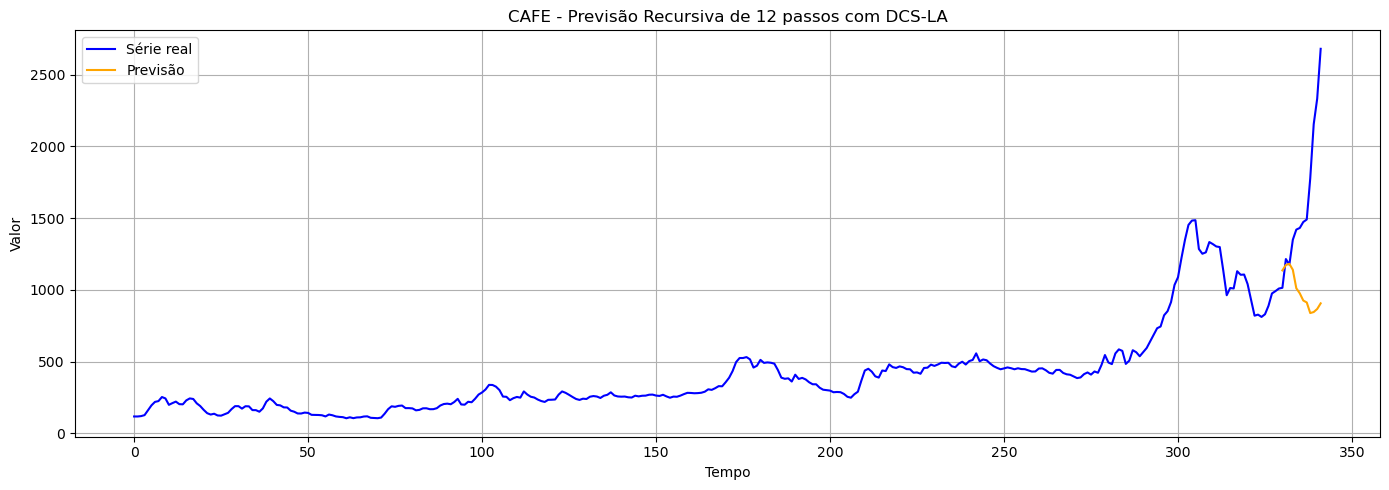


==> Série: MILHO
Valores reais:     [62.72, 59.63, 58.92, 57.86, 57.22, 59.58, 62.6, 68.79, 73.68, 72.92, 74.17, 77.97]
Valores previstos: [70.4, 67.15, 69.39, 69.31, 69.82, 68.36, 69.3, 68.89, 69.24, 69.08, 69.18, 69.05]
MSE da previsão recursiva (12 passos): 64.6671


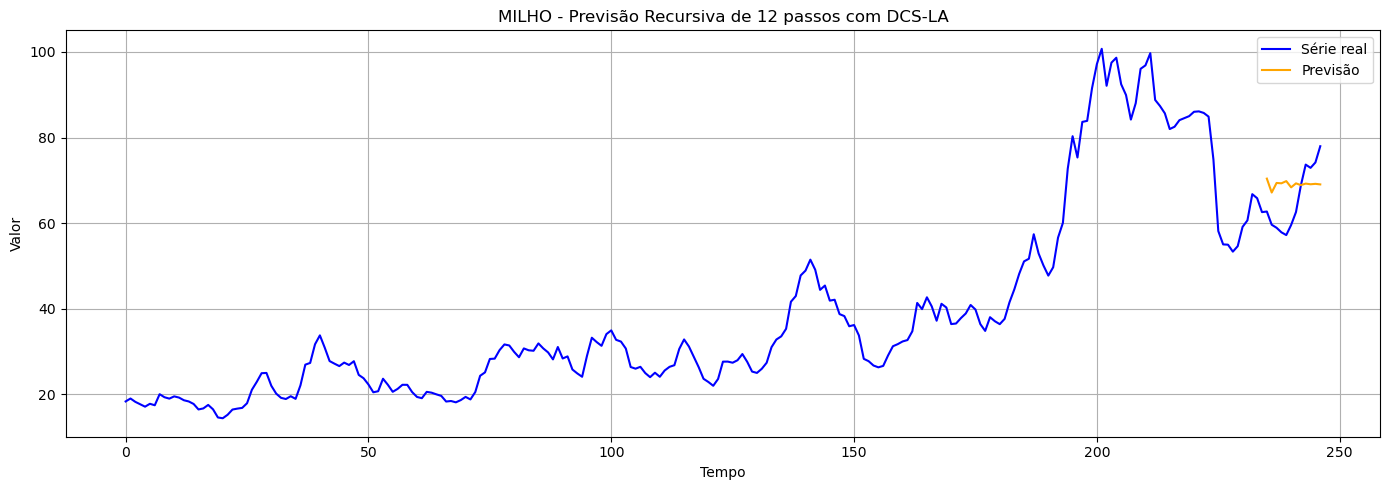


==> Série: SOJA
Valores reais:     [121.91, 126.79, 136.0, 138.92, 138.09, 133.21, 139.9, 141.83, 143.41, 141.17, 134.62, 131.1]
Valores previstos: [141.33, 136.13, 136.3, 139.16, 146.74, 140.05, 137.3, 137.47, 135.78, 133.36, 131.59, 133.29]
MSE da previsão recursiva (12 passos): 62.0981


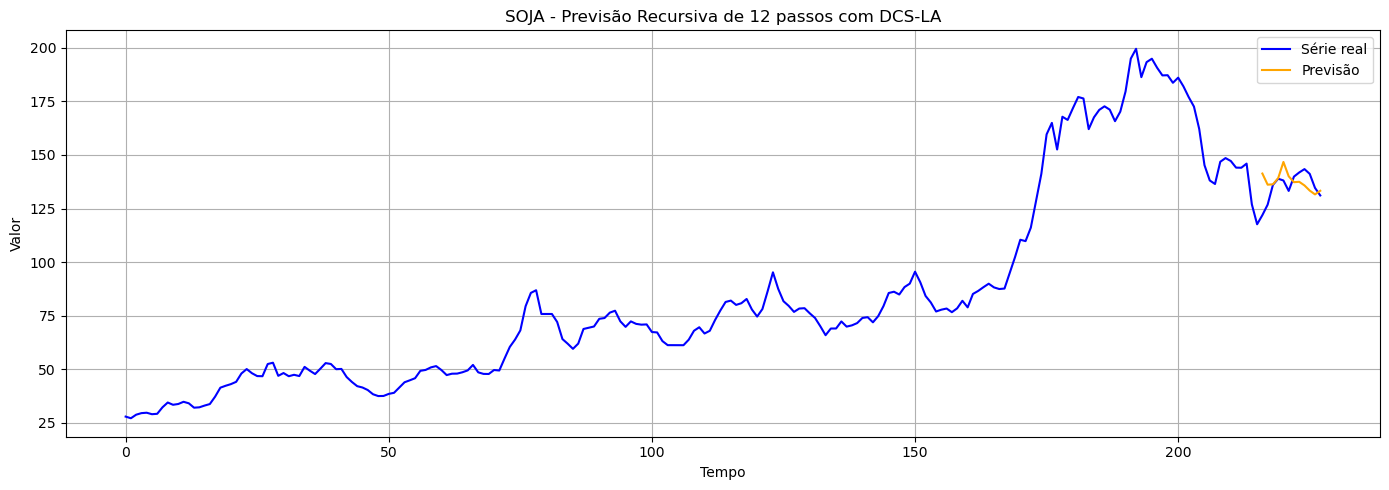

In [ ]:
for id in df_brl['unique_id'].unique():
    print(f'\n==> Série: {id}')

    y_series = series_data_brl[id]['y_series']     # array com os valores alvo da série
    y_real_future = y_series[-horizon_size:]       # últimos 12 pontos reais para avaliação
    y_train = y_series[:-horizon_size]             # parte separada para gerar as janelas e treinar os modelos

    curr_lags = y_train[-window_size:]             # criação da primeira região de dependência (últimos *window_size* pontos do treino)
    forecast = []                                  # lista para add os *horizon_size* valores previstos

    for step in range(horizon_size):
        # extrai janelas e targets do histórico até agora (incluindo previsões anteriores)
        windows, targets = extract_lag_windows(y_train, window_size=window_size)

        # calcula similaridade da região atual com todas janelas anteriores
        dists = euclidean_distances([curr_lags], windows)[0]
        top_k_idx = dists.argsort()[:10]  # top 10 janelas mais próximas (menores distâncias)

        competence_X = windows[top_k_idx]
        competence_y = targets[top_k_idx]

        # seleciona o melhor modelo com base no erro (MSE)
        errors = evaluate_models(models, competence_X, competence_y)
        best_model = models[np.argmin(errors)]

        # realiza a previsão para o próximo ponto
        y_next = best_model.predict([curr_lags])[0]
        forecast.append(y_next)

        # atualiza os lags e o histórico com o valor previsto
        curr_lags = np.append(curr_lags[1:], y_next)
        y_train = np.append(y_train, y_next)

    # avaliação dos valores reais e previstos + mse
    print("Valores reais:    ", y_real_future.round(2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    mse = mean_squared_error(y_real_future, forecast)
    print(f"MSE da previsão recursiva ({horizon_size} passos): {mse:.4f}")

    plot_forecast(y_series, forecast, horizon_size, id)

## USD

### Similaridade por Cosseno


==> Série: ACUCAR
Valores reais:     [28.84, 28.72, 27.06, 25.17, 24.0, 23.55, 25.48, 27.15, 28.68, 26.51, 25.82, 25.23]
Valores previstos: [21.42, 23.44, 20.79, 17.16, 17.61, 17.54, 16.55, 17.17, 15.74, 14.52, 15.65, 16.41]
MSE da previsão recursiva (12 passos): 77.9299


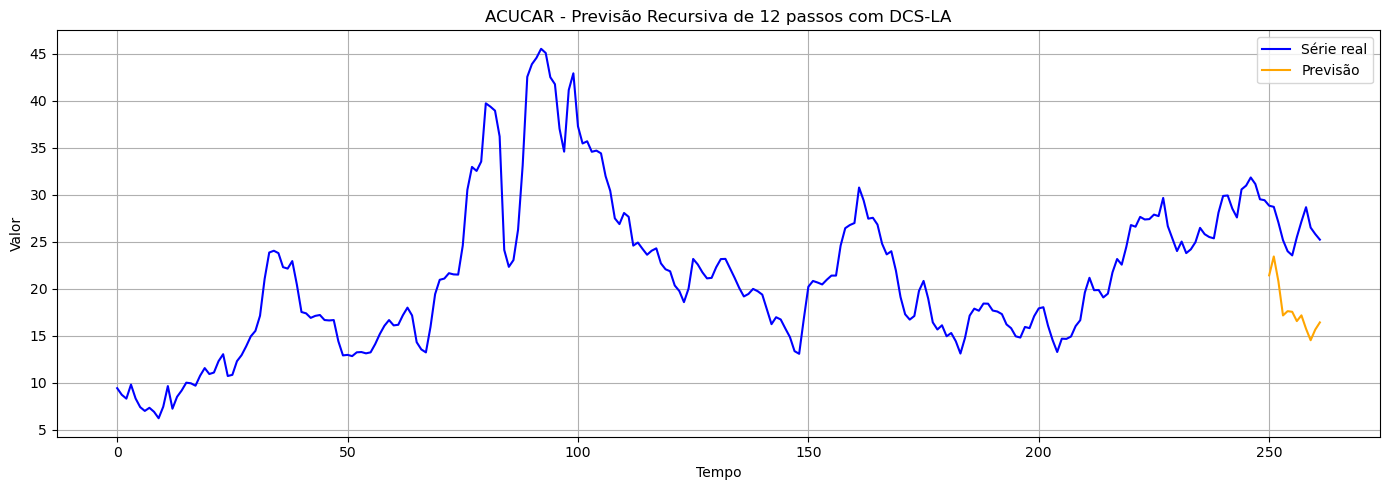


==> Série: ALGODAO
Valores reais:     [84.43, 77.64, 74.9, 72.75, 73.4, 71.95, 71.49, 70.42, 68.08, 67.89, 68.92, 71.48]
Valores previstos: [82.37, 83.25, 83.03, 81.97, 82.0, 81.02, 81.75, 81.36, 81.11, 81.84, 81.6, 81.62]
MSE da previsão recursiva (12 passos): 99.6408


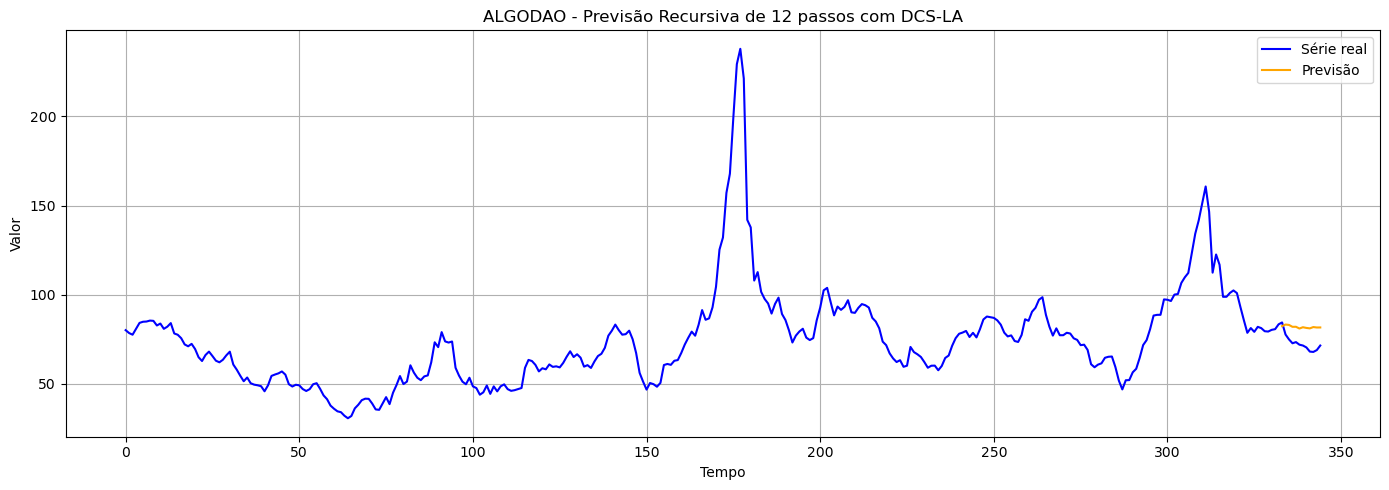


==> Série: CAFE
Valores reais:     [203.66, 236.77, 228.75, 250.16, 256.06, 257.86, 265.93, 264.88, 305.73, 353.49, 388.16, 465.36]
Valores previstos: [213.1, 157.22, 166.34, 166.69, 150.95, 166.92, 155.41, 153.7, 145.29, 145.07, 131.41, 124.78]
MSE da previsão recursiva (12 passos): 26022.5975


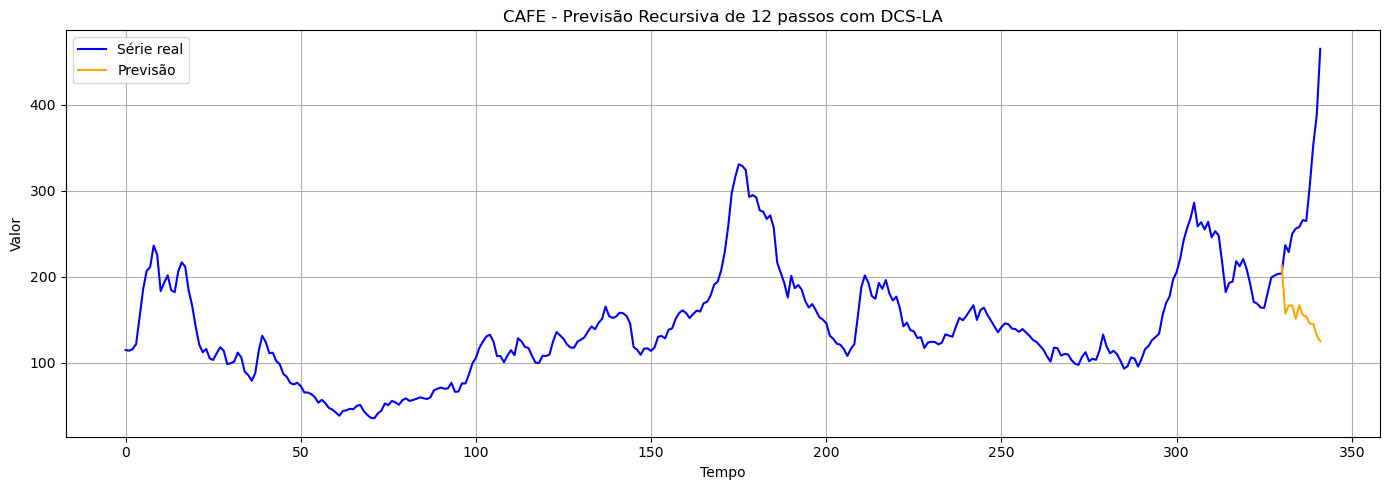


==> Série: MILHO
Valores reais:     [12.6, 11.64, 11.47, 10.73, 10.32, 10.73, 11.3, 12.22, 12.7, 11.96, 12.34, 13.54]
Valores previstos: [11.67, 10.01, 9.93, 9.24, 9.68, 10.35, 10.15, 11.03, 12.92, 13.76, 14.4, 14.64]
MSE da previsão recursiva (12 passos): 1.6802


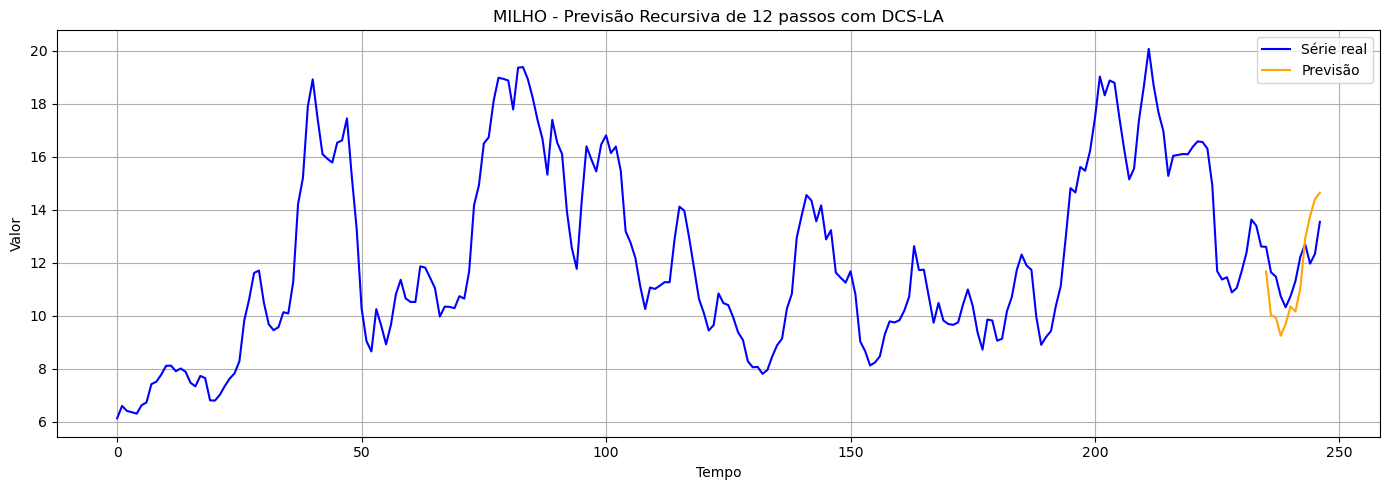


==> Série: SOJA
Valores reais:     [24.49, 24.74, 26.47, 25.76, 24.9, 23.99, 25.26, 25.22, 24.71, 23.17, 22.38, 22.77]
Valores previstos: [26.09, 27.61, 29.75, 30.38, 29.74, 30.56, 30.39, 30.9, 29.91, 28.92, 29.13, 29.3]
MSE da previsão recursiva (12 passos): 26.3889


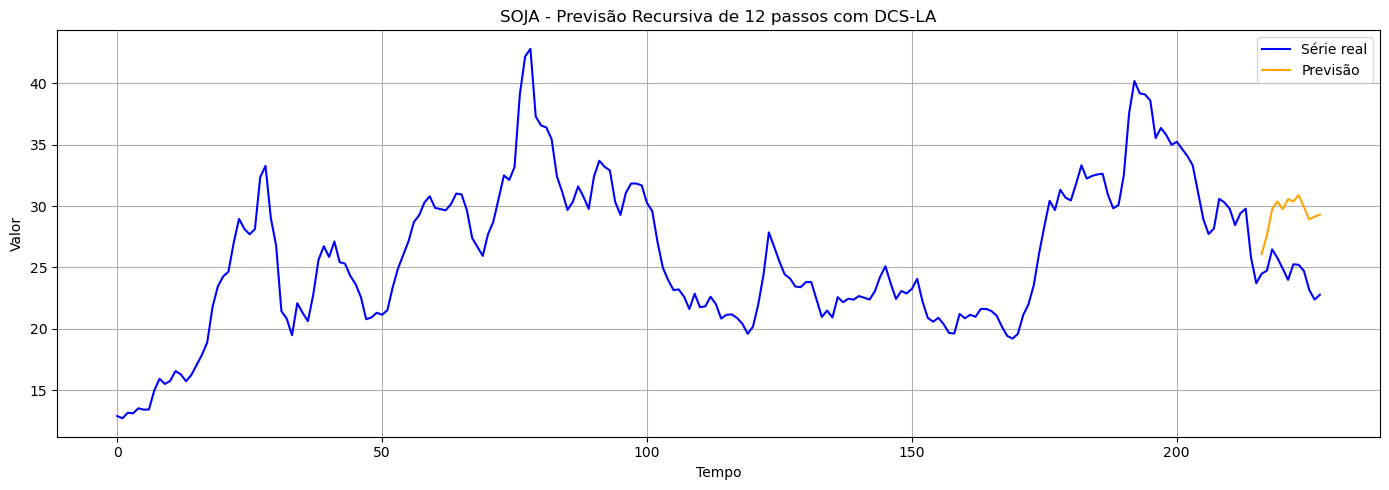

In [ ]:
for id in df_usd['unique_id'].unique():
    print(f'\n==> Série: {id}')

    y_series = series_data_usd[id]['y_series']
    y_real_future = y_series[-horizon_size:]
    y_train = y_series[:-horizon_size]

    curr_lags = y_train[-window_size:]
    forecast = []

    for step in range(horizon_size):
        windows, targets = extract_lag_windows(y_train, window_size=window_size)

        sims = cosine_similarity([curr_lags], windows)[0]
        top_k_idx = sims.argsort()[-10:]

        competence_X = windows[top_k_idx]
        competence_y = targets[top_k_idx]

        errors = evaluate_models(models, competence_X, competence_y)
        best_model = models[np.argmin(errors)]

        y_next = best_model.predict([curr_lags])[0]
        forecast.append(y_next)

        curr_lags = np.append(curr_lags[1:], y_next)
        y_train = np.append(y_train, y_next)

    print("Valores reais:    ", y_real_future.round(2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    mse = mean_squared_error(y_real_future, forecast)
    print(f"MSE da previsão recursiva ({horizon_size} passos): {mse:.4f}")

    plot_forecast(y_series, forecast, horizon_size, id)

### Similaridade por Distância Euclidiana


==> Série: ACUCAR
Valores reais:     [28.84, 28.72, 27.06, 25.17, 24.0, 23.55, 25.48, 27.15, 28.68, 26.51, 25.82, 25.23]
Valores previstos: [30.31, 30.3, 30.01, 30.66, 29.92, 30.17, 30.25, 30.23, 30.2, 30.27, 30.17, 30.23]
MSE da previsão recursiva (12 passos): 17.9106


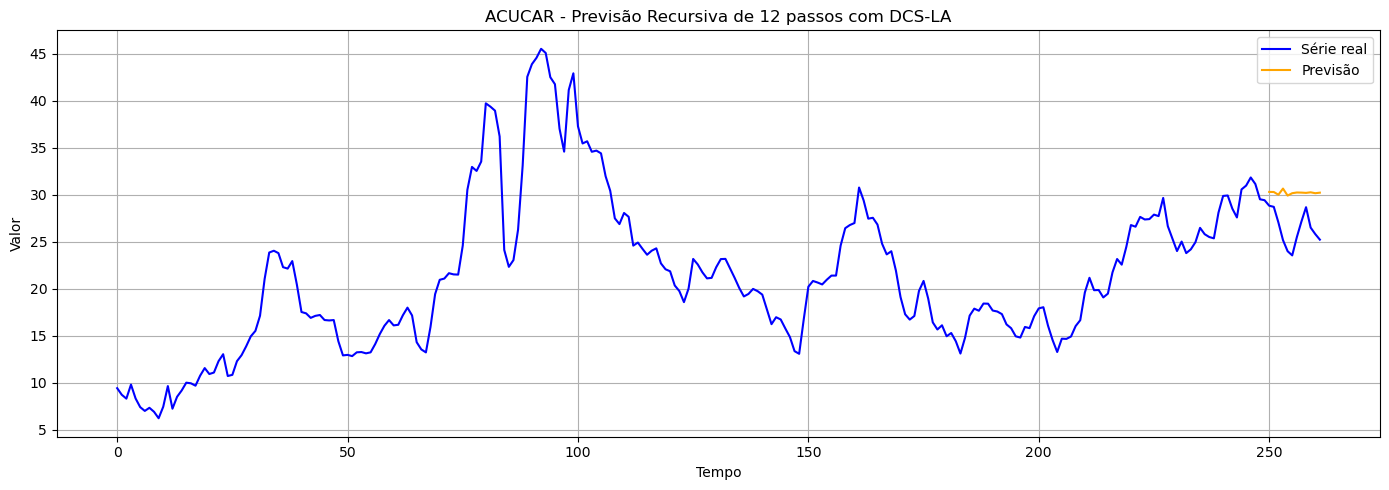


==> Série: ALGODAO
Valores reais:     [84.43, 77.64, 74.9, 72.75, 73.4, 71.95, 71.49, 70.42, 68.08, 67.89, 68.92, 71.48]
Valores previstos: [81.09, 81.62, 80.76, 81.01, 80.46, 81.16, 81.29, 81.51, 81.37, 81.23, 81.2, 81.3]
MSE da previsão recursiva (12 passos): 90.4186


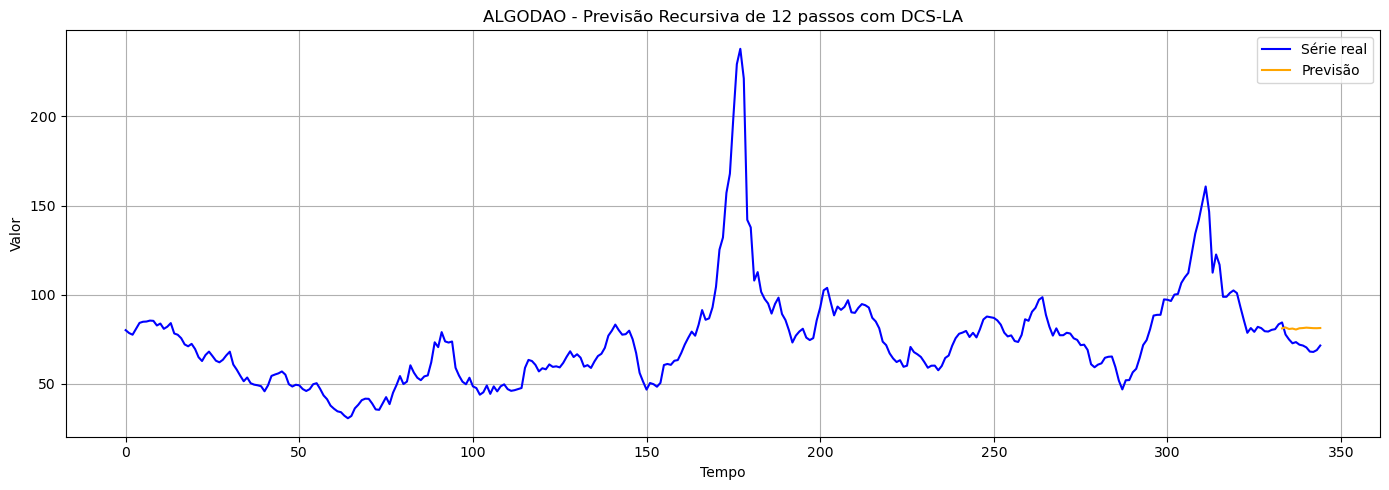


==> Série: CAFE
Valores reais:     [203.66, 236.77, 228.75, 250.16, 256.06, 257.86, 265.93, 264.88, 305.73, 353.49, 388.16, 465.36]
Valores previstos: [224.57, 242.82, 261.7, 284.38, 289.93, 283.04, 270.93, 256.01, 251.73, 248.82, 235.52, 223.6]
MSE da previsão recursiva (12 passos): 8353.0135


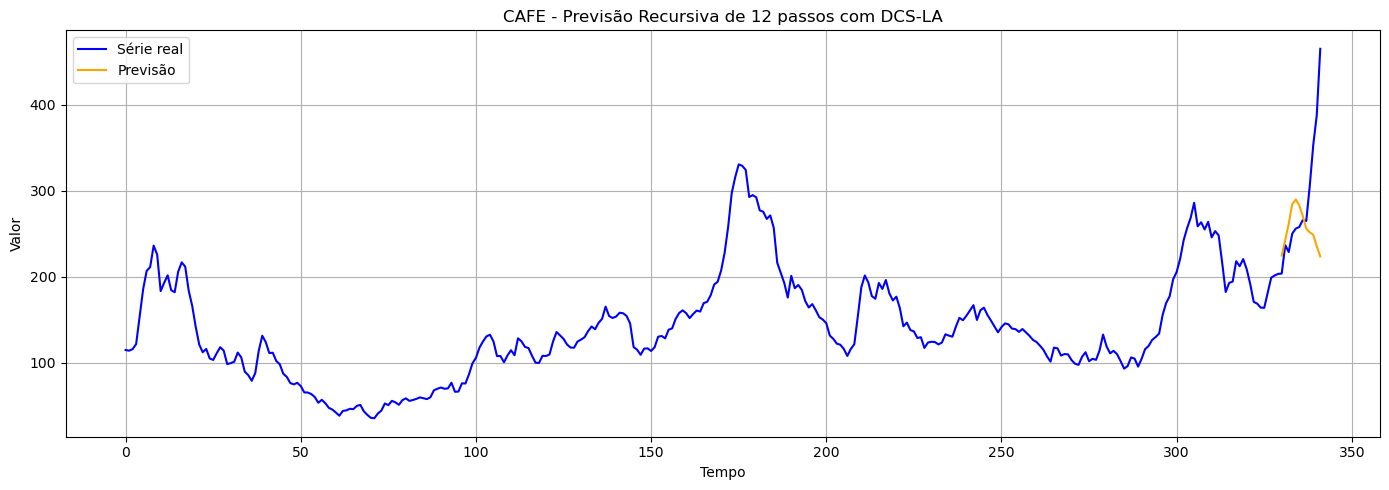


==> Série: MILHO
Valores reais:     [12.6, 11.64, 11.47, 10.73, 10.32, 10.73, 11.3, 12.22, 12.7, 11.96, 12.34, 13.54]
Valores previstos: [12.44, 11.69, 10.94, 10.75, 10.52, 10.34, 10.53, 10.63, 10.91, 11.71, 12.81, 13.69]
MSE da previsão recursiva (12 passos): 0.5975


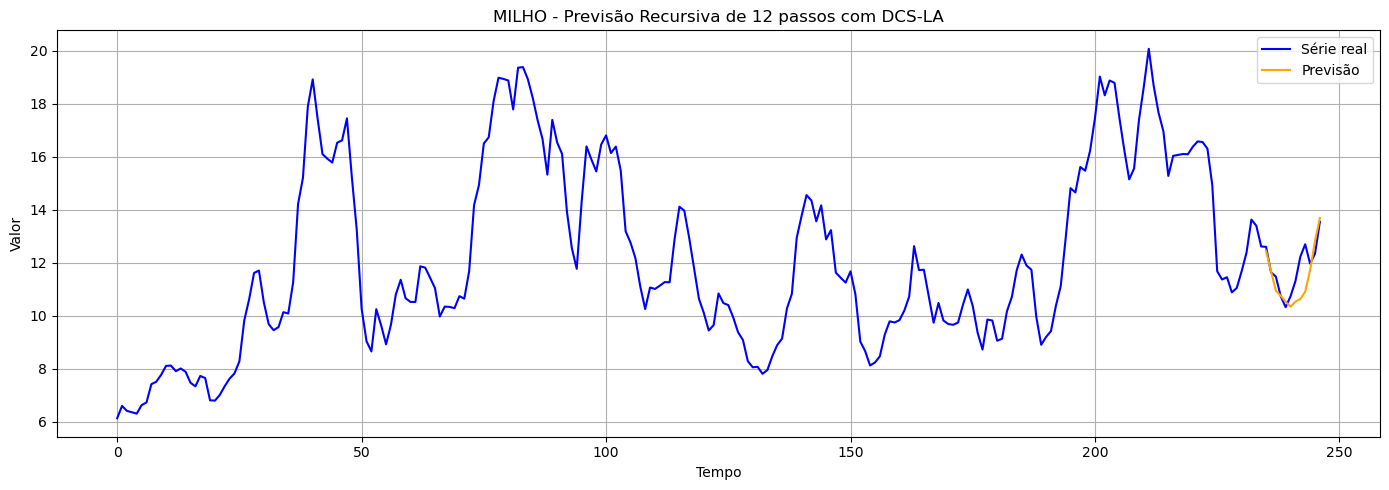


==> Série: SOJA
Valores reais:     [24.49, 24.74, 26.47, 25.76, 24.9, 23.99, 25.26, 25.22, 24.71, 23.17, 22.38, 22.77]
Valores previstos: [25.69, 25.25, 24.08, 22.51, 22.18, 22.47, 22.48, 22.91, 22.62, 22.69, 22.92, 23.43]
MSE da previsão recursiva (12 passos): 3.8355


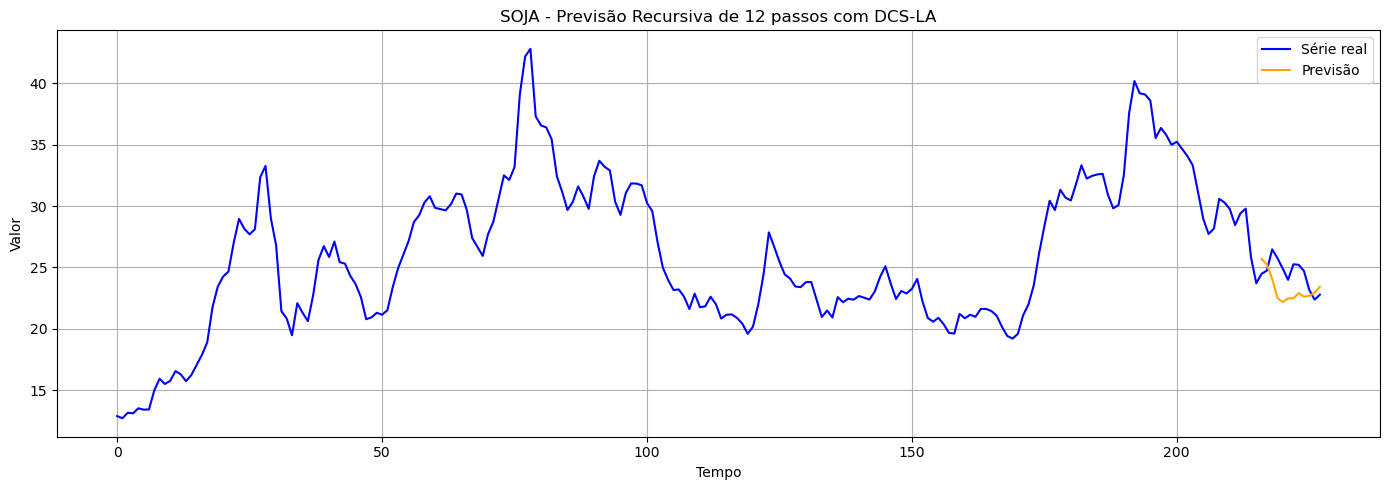

In [ ]:
for id in df_usd['unique_id'].unique():
    print(f'\n==> Série: {id}')

    y_series = series_data_usd[id]['y_series']
    y_real_future = y_series[-horizon_size:]
    y_train = y_series[:-horizon_size]

    curr_lags = y_train[-window_size:]
    forecast = []

    for step in range(horizon_size):
        windows, targets = extract_lag_windows(y_train, window_size=window_size)

        dists = euclidean_distances([curr_lags], windows)[0]
        top_k_idx = dists.argsort()[:10]

        competence_X = windows[top_k_idx]
        competence_y = targets[top_k_idx]

        errors = evaluate_models(models, competence_X, competence_y)
        best_model = models[np.argmin(errors)]

        y_next = best_model.predict([curr_lags])[0]
        forecast.append(y_next)

        curr_lags = np.append(curr_lags[1:], y_next)
        y_train = np.append(y_train, y_next)

    print("Valores reais:    ", y_real_future.round(2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    mse = mean_squared_error(y_real_future, forecast)
    print(f"MSE da previsão recursiva ({horizon_size} passos): {mse:.4f}")

    plot_forecast(y_series, forecast, horizon_size, id)